## the boring stuff

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [69]:
import time
import xgboost as xgb
import lightgbm as lgb
import category_encoders as cat_ed
import gc, mlcrate, glob

from gplearn.genetic import SymbolicTransformer
from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, RandomForestRegressor
from IPython.display import display
from catboost import CatBoostClassifier, CatBoostRegressor
from scipy.cluster import hierarchy as hc
from collections import Counter

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import  roc_auc_score, log_loss
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA, TruncatedSVD, FastICA, FactorAnalysis
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
from sklearn.cluster import KMeans

from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

# will ignore all warning from sklearn, seaborn etc..
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

pd.option_context("display.max_rows", 1000);
pd.option_context("display.max_columns", 1000);

In [3]:
PATH = os.getcwd()

In [4]:
df_raw = pd.read_csv(f'{PATH}\\train_new_agg_feats.csv', low_memory=False)
df_test = pd.read_csv(f'{PATH}\\test_new_agg_feats.csv', low_memory=False)

In [5]:
def display_all(df):
    with pd.option_context("display.max_rows", 100): 
        with pd.option_context("display.max_columns", 100): 
            display(df)

def make_submission(probs):
    sample = pd.read_csv(f'{PATH}\\sample_submission.csv')
    submit = sample.copy()
    submit['Upvotes'] = probs
    return submit

In [6]:
df_raw.shape,

((330045, 20),)

In [7]:
df_raw.get_ftype_counts()

float64:dense    20
dtype: int64

In [8]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

Answers                  0.0
Reputation               0.0
Tag                      0.0
Username                 0.0
Views                    0.0
agg_answers              0.0
agg_count                0.0
agg_repo                 0.0
agg_views                0.0
log_trans_Answers        0.0
log_trans_Reputation     0.0
log_trans_Username       0.0
log_trans_Views          0.0
log_trans_agg_answers    0.0
log_trans_agg_count      0.0
log_trans_agg_repo       0.0
log_trans_agg_views      0.0
repo_per_Answers         0.0
repo_per_Views           0.0
target                   0.0
dtype: float64

## random

In [41]:
df_raw.head()

,Tag,Reputation,Answers,Username,Views,agg_count,agg_answers,agg_views,agg_repo,log_trans_Reputation,log_trans_Answers,log_trans_Username,log_trans_Views,log_trans_agg_count,log_trans_agg_answers,log_trans_agg_views,log_trans_agg_repo,repo_per_Answers,repo_per_Views,target
4,1.0,4271.0,4.0,112223.0,13986.0,3.0,2.0,20598.0,4271.0,8.359838,1.609438,11.628252,9.545883,1.386294,1.098612,9.932998,8.359838,854.200012,0.305377,84.000000
7,4.0,2269.0,2.0,54623.0,312.0,7.0,2.0,4168.0,2269.0,7.727535,1.098612,10.908229,5.746203,2.079442,1.098612,8.335431,7.727535,756.333313,7.272436,4.000000
8,4.0,111.0,2.0,172926.0,53738.0,1.0,2.0,53738.0,111.0,4.718499,1.098612,12.060625,10.891894,0.693147,1.098612,10.891894,4.718499,37.000000,0.002066,80.000008
15,1.0,7952.0,2.0,62155.0,29191.0,4.0,3.0,28314.0,7952.0,8.981304,1.098612,11.037403,10.281650,1.609438,1.386294,10.251147,8.981304,2650.666748,0.272413,224.000015
16,3.0,731.0,4.0,43559.0,5622.0,2.0,2.0,6730.0,731.0,6.595780,1.609438,10.681894,8.634621,1.098612,1.098612,8.814479,6.595780,146.199997,0.130025,14.000001


In [45]:
df_raw = pd.get_dummies(df_raw, 'tag', columns=['Tag'])

In [49]:
df_test = pd.get_dummies(df_test, 'tag', columns=['Tag'])

## Bazooka ! (anokas)

In [34]:
man_train_list = df_raw.Username.unique()
man_test_list = df_test.Username.unique()

man_not_in_test = set(man_train_list) - set(man_test_list)
man_not_in_train = set(man_test_list) - set(man_train_list)

In [35]:
df_raw.drop(index = df_raw.loc[list(man_not_in_test)].index, inplace=True)

In [100]:
model=CatBoostRegressor(iterations=500, learning_rate= 0.06, depth = 8, loss_function='RMSE')

In [101]:
model.fit(df_raw, target)

0:	learn: 3063.2371640	total: 241ms	remaining: 2m
1:	learn: 2960.8726708	total: 482ms	remaining: 1m 59s
2:	learn: 2859.8232707	total: 725ms	remaining: 2m
3:	learn: 2763.7387297	total: 962ms	remaining: 1m 59s
4:	learn: 2674.4727651	total: 1.2s	remaining: 1m 58s
5:	learn: 2593.9050737	total: 1.45s	remaining: 1m 58s
6:	learn: 2518.4998525	total: 1.68s	remaining: 1m 58s
7:	learn: 2447.5342017	total: 1.92s	remaining: 1m 57s
8:	learn: 2377.0639722	total: 2.14s	remaining: 1m 57s
9:	learn: 2309.8472468	total: 2.36s	remaining: 1m 55s
10:	learn: 2252.9853105	total: 2.59s	remaining: 1m 54s
11:	learn: 2201.9552468	total: 2.81s	remaining: 1m 54s
12:	learn: 2155.0355269	total: 3.05s	remaining: 1m 54s
13:	learn: 2109.8449006	total: 3.29s	remaining: 1m 54s
14:	learn: 2063.1868582	total: 3.51s	remaining: 1m 53s
15:	learn: 2018.2463731	total: 3.74s	remaining: 1m 53s
16:	learn: 1980.3793067	total: 3.96s	remaining: 1m 52s
17:	learn: 1941.8133946	total: 4.18s	remaining: 1m 52s
18:	learn: 1909.5766205	total

149:	learn: 999.9606264	total: 36.8s	remaining: 1m 25s
150:	learn: 997.7357668	total: 37s	remaining: 1m 25s
151:	learn: 992.5900040	total: 37.2s	remaining: 1m 25s
152:	learn: 991.7642291	total: 37.4s	remaining: 1m 24s
153:	learn: 991.4635386	total: 37.6s	remaining: 1m 24s
154:	learn: 989.8268487	total: 37.9s	remaining: 1m 24s
155:	learn: 989.2420901	total: 38.2s	remaining: 1m 24s
156:	learn: 987.3081136	total: 38.4s	remaining: 1m 23s
157:	learn: 986.7190499	total: 38.7s	remaining: 1m 23s
158:	learn: 985.3585718	total: 39s	remaining: 1m 23s
159:	learn: 985.0191420	total: 39.3s	remaining: 1m 23s
160:	learn: 981.9221194	total: 39.5s	remaining: 1m 23s
161:	learn: 981.4420216	total: 39.8s	remaining: 1m 23s
162:	learn: 980.7993257	total: 40.1s	remaining: 1m 22s
163:	learn: 979.4011786	total: 40.3s	remaining: 1m 22s
164:	learn: 979.3289771	total: 40.6s	remaining: 1m 22s
165:	learn: 978.9966721	total: 40.9s	remaining: 1m 22s
166:	learn: 978.2825344	total: 41.2s	remaining: 1m 22s
167:	learn: 97

301:	learn: 794.4154340	total: 1m 13s	remaining: 48.4s
302:	learn: 791.8650076	total: 1m 14s	remaining: 48.1s
303:	learn: 790.4335313	total: 1m 14s	remaining: 47.9s
304:	learn: 789.3009397	total: 1m 14s	remaining: 47.7s
305:	learn: 787.7721690	total: 1m 14s	remaining: 47.5s
306:	learn: 786.9612054	total: 1m 15s	remaining: 47.3s
307:	learn: 786.4413806	total: 1m 15s	remaining: 47.1s
308:	learn: 785.6216395	total: 1m 15s	remaining: 46.9s
309:	learn: 785.4690526	total: 1m 16s	remaining: 46.7s
310:	learn: 784.7599126	total: 1m 16s	remaining: 46.4s
311:	learn: 783.8655334	total: 1m 16s	remaining: 46.2s
312:	learn: 782.7737148	total: 1m 16s	remaining: 46s
313:	learn: 780.5268743	total: 1m 17s	remaining: 45.7s
314:	learn: 779.6913249	total: 1m 17s	remaining: 45.5s
315:	learn: 779.6776446	total: 1m 17s	remaining: 45.2s
316:	learn: 776.4204172	total: 1m 17s	remaining: 44.9s
317:	learn: 776.1585568	total: 1m 18s	remaining: 44.7s
318:	learn: 774.2847859	total: 1m 18s	remaining: 44.4s
319:	learn: 

451:	learn: 668.7162450	total: 1m 49s	remaining: 11.7s
452:	learn: 667.6379633	total: 1m 50s	remaining: 11.4s
453:	learn: 667.2526721	total: 1m 50s	remaining: 11.2s
454:	learn: 666.8589603	total: 1m 50s	remaining: 10.9s
455:	learn: 665.6129627	total: 1m 50s	remaining: 10.7s
456:	learn: 665.4283978	total: 1m 51s	remaining: 10.5s
457:	learn: 664.9031034	total: 1m 51s	remaining: 10.2s
458:	learn: 664.4429432	total: 1m 51s	remaining: 9.97s
459:	learn: 662.7554730	total: 1m 51s	remaining: 9.73s
460:	learn: 661.7949838	total: 1m 52s	remaining: 9.49s
461:	learn: 661.1719274	total: 1m 52s	remaining: 9.24s
462:	learn: 661.0261829	total: 1m 52s	remaining: 9s
463:	learn: 660.4675751	total: 1m 52s	remaining: 8.76s
464:	learn: 659.2579658	total: 1m 53s	remaining: 8.52s
465:	learn: 658.8995971	total: 1m 53s	remaining: 8.28s
466:	learn: 658.3467436	total: 1m 53s	remaining: 8.04s
467:	learn: 658.0117440	total: 1m 53s	remaining: 7.79s
468:	learn: 656.8870599	total: 1m 54s	remaining: 7.55s
469:	learn: 6

In [104]:
preds = model.predict(df_test) - 1;
preds[:10]

array([ 190.38626,  141.29875,   62.31854,    4.08713,  291.0547 ,   36.24614,   16.04935,   76.81639,
         63.33431,   24.40927])

In [105]:
submit = make_submission(preds)

In [106]:
submit.to_csv(f'{PATH}\\Adi_catboost_with rf_feats_310818.csv', index=None)

## RF

In [54]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = ['RMSLE X_train', rmse(m.predict(X_train), y_train), '\n RMSLE X_valid', rmse(m.predict(X_valid), y_valid),
                '\n R**2 Train',m.score(X_train, y_train), '\n R**2 Valid', m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(['\n OOB_Score', m.oob_score_])
    print(res)

In [56]:
target = df_raw.target

In [57]:
df_raw.drop('target', axis=1,inplace=True)

In [78]:
df_raw.drop('Username', axis=1,inplace=True)
df_test.drop('Username', axis=1,inplace=True)

In [79]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(df_raw, target, test_size=0.2, random_state=42)

def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 30000
n_trn = len(df_raw)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df_raw, n_trn)
y_train, y_valid = split_vals(target, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((203657, 27), (203657,), (30000, 27))

In [87]:
df_raw.drop(['Reputation', 'Answers', 'Views'], axis=1, inplace=True)
df_test.drop(['Reputation', 'Answers', 'Views'], axis=1, inplace=True)

In [ ]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True, max_depth= 8)
m.fit(X_train, y_train)
print_score(m)

In [81]:
df_raw.head()

,Reputation,Answers,Views,agg_count,agg_answers,agg_views,agg_repo,log_trans_Reputation,log_trans_Answers,log_trans_Username,...,tag_0.0,tag_1.0,tag_2.0,tag_3.0,tag_4.0,tag_5.0,tag_6.0,tag_7.0,tag_8.0,tag_9.0
4,4271.0,4.0,13986.0,3.0,2.0,20598.0,4271.0,8.359838,1.609438,11.628252,...,0,1,0,0,0,0,0,0,0,0
7,2269.0,2.0,312.0,7.0,2.0,4168.0,2269.0,7.727535,1.098612,10.908229,...,0,0,0,0,1,0,0,0,0,0
8,111.0,2.0,53738.0,1.0,2.0,53738.0,111.0,4.718499,1.098612,12.060625,...,0,0,0,0,1,0,0,0,0,0
15,7952.0,2.0,29191.0,4.0,3.0,28314.0,7952.0,8.981304,1.098612,11.037403,...,0,1,0,0,0,0,0,0,0,0
16,731.0,4.0,5622.0,2.0,2.0,6730.0,731.0,6.595780,1.609438,10.681894,...,0,0,0,1,0,0,0,0,0,0


In [86]:
df_raw.columns

Index(['Reputation', 'Answers', 'Views', 'agg_count', 'agg_answers',
       'agg_views', 'agg_repo', 'log_trans_Reputation', 'log_trans_Answers',
       'log_trans_Username', 'log_trans_Views', 'log_trans_agg_count',
       'log_trans_agg_answers', 'log_trans_agg_views', 'log_trans_agg_repo',
       'repo_per_Answers', 'repo_per_Views', 'tag_0.0', 'tag_1.0', 'tag_2.0',
       'tag_3.0', 'tag_4.0', 'tag_5.0', 'tag_6.0', 'tag_7.0', 'tag_8.0',
       'tag_9.0'],
      dtype='object')

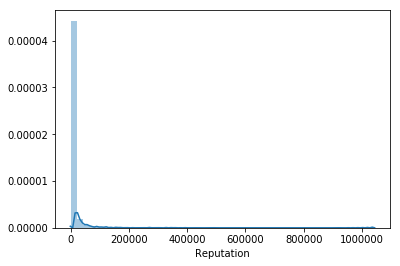

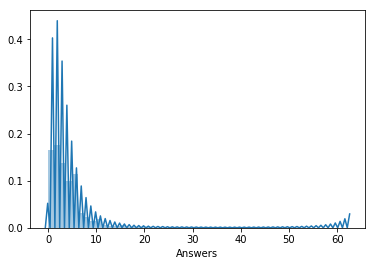

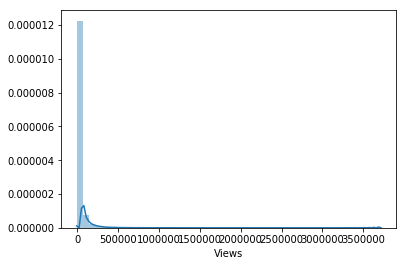

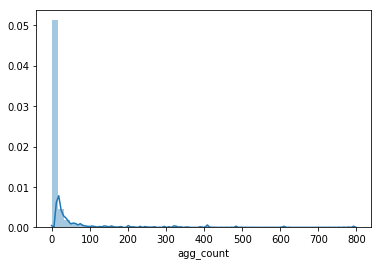

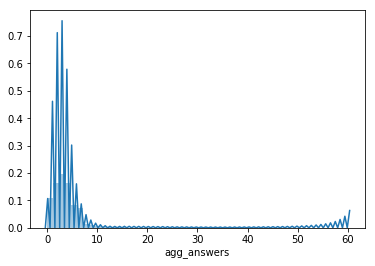

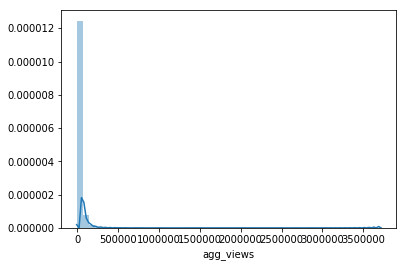

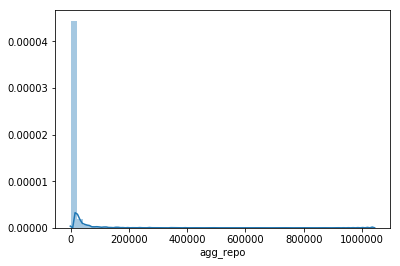

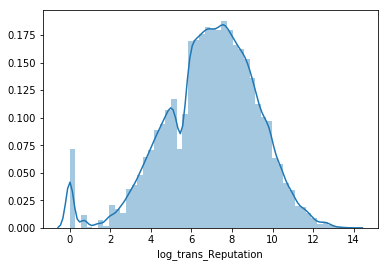

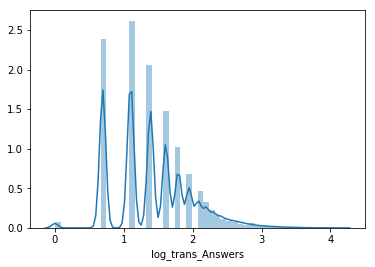

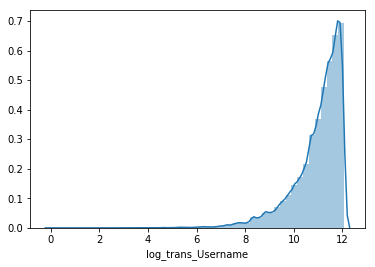

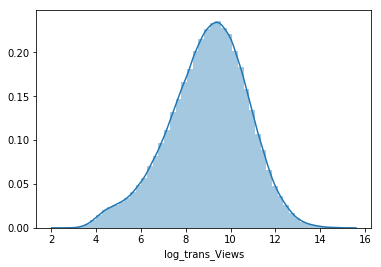

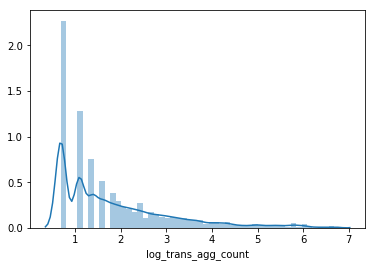

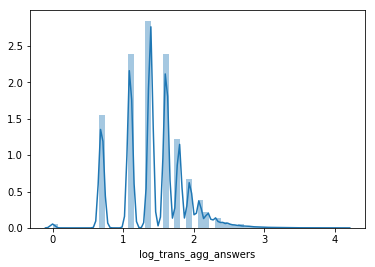

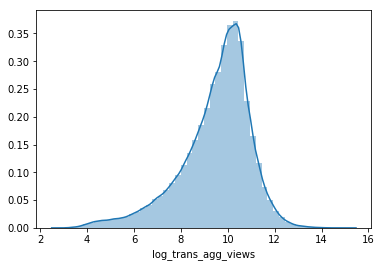

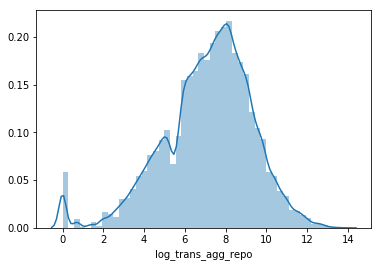

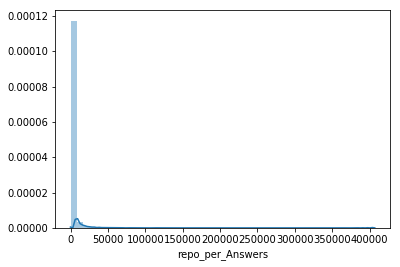

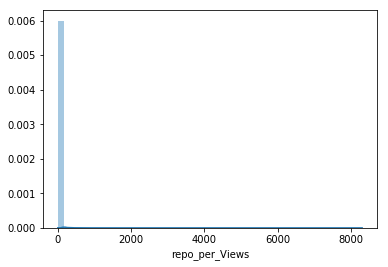

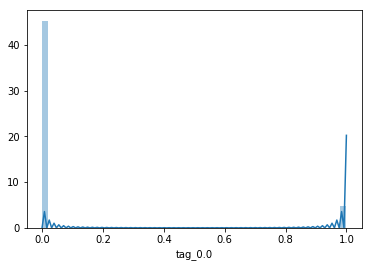

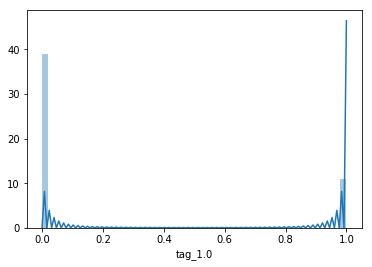

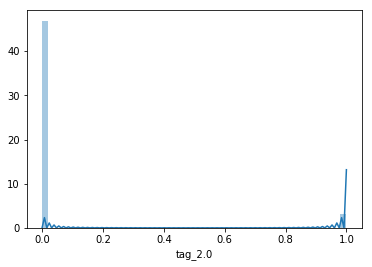

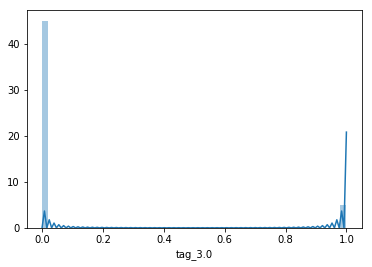

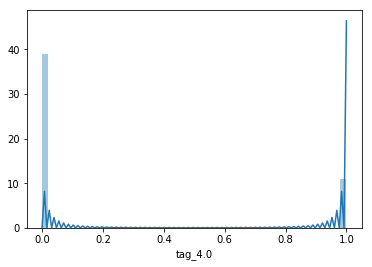

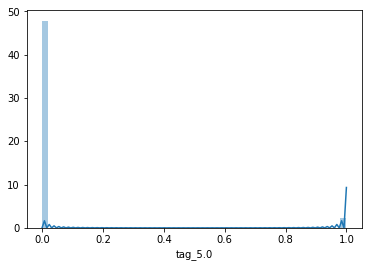

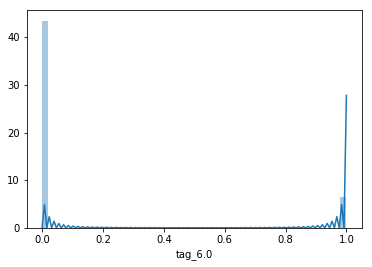

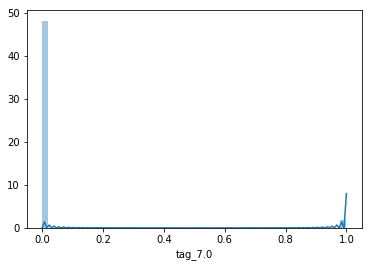

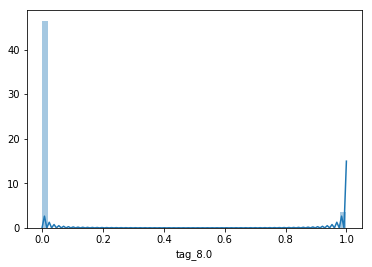

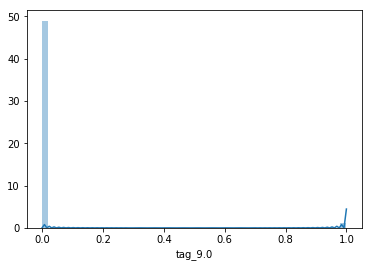

In [85]:
for i in df_raw.columns:
    sns.distplot(df_raw[i])
    plt.show()